# DDPG Main

## Data Preprocessing

In [323]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import gymnasium
from gymnasium import spaces


# Load data
#C:\Users\rohit\OneDrive\Documents\Asset-Pricing-with-Reinforcement-Learning\XOM_30_minute_6_month_data.csv
df = pd.read_csv('XOM_30_minute_6_month_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Calculate the 10-period moving average
# df['10_MA'] = df['Last Price'].rolling(window=10).mean()
# df.to_csv('XOM_30_minute_6_month_data.csv', index=False)

# Used for unnormalization
last_price_scaler = MinMaxScaler()
last_price_scaler.fit(df[['Last Price']])
# Normalise data
scaler = MinMaxScaler()
df[['Last Price', 'Volume', 'SMAVG (15)', '10_MA']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)', '10_MA']])


# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print(train_df[10:])

                    Date  Last Price    Volume  SMAVG (15)     10_MA
10   2023-03-08 18:00:00    0.499995  0.043372    0.074594  0.544225
11   2023-03-08 18:30:00    0.521974  0.046837    0.076402  0.535888
12   2023-03-08 19:00:00    0.527885  0.038593    0.075786  0.527086
13   2023-03-08 19:30:00    0.505948  0.067524    0.078888  0.512765
14   2023-03-08 20:00:00    0.492211  0.085734    0.084456  0.499824
...                  ...         ...       ...         ...       ...
1861 2023-10-02 15:00:00    0.755034  0.144825    0.184963  0.865106
1862 2023-10-02 15:30:00    0.762818  0.113712    0.166506  0.851449
1863 2023-10-02 16:00:00    0.764192  0.092697    0.157100  0.838893
1864 2023-10-02 16:30:00    0.761445  0.078738    0.145187  0.827026
1865 2023-10-02 17:00:00    0.771747  0.055809    0.135850  0.818920

[1856 rows x 5 columns]


## Environment

In [324]:
class DDPGTradingEnv(gymnasium.Env):

  def __init__(self, df):
    super().__init__()
    
    self.df = df
    self.current_step = 0
    self.total_steps = 650 #len(df) - 1

    # Negatives mean quantity to sell, 0 is hold, positives mean buy
    self.action_space = spaces.Box(low=-1, high=1, shape=(1, ), dtype=np.float32)
    # Observation space: normalized last price, normalized shares held, normalized cash balance
    self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    self.reset()

  def reset(self):
    self.current_step = 0
    self.total_profit = 0
    self.cash_balance = 10000
    self.max_share_order = 90
    self.shares_held = 0
    self.portfolio_value = self.cash_balance
    self.previous_portfolio_value = self.portfolio_value
    # For plotting
    self.portfolio_history = [np.array([self.portfolio_value], dtype=np.float32)]

    return self.get_observation()

  def get_observation(self):
    current_price = self.df.loc[self.current_step, 'Last Price']
    volume = self.df['Volume'].iloc[self.current_step]
    MA_10 = self.df['10_MA'].iloc[self.current_step]
    return np.array([float(current_price), float(self.shares_held), float(self.cash_balance), float(volume), float(MA_10)])

  def take_action(self, num_shares):
    normalised_current_price = self.df.loc[self.current_step, 'Last Price']
    # Inverse transform to get the un-normalized current price
    current_price = last_price_scaler.inverse_transform([[normalised_current_price]])
    # Checks if we have enough cash to buy
    print("num_shares: ", num_shares)
    print("current_price: ", current_price)
    if num_shares > 0 and self.cash_balance > (num_shares*current_price):
      self.buy_stock(num_shares, current_price)
    # Checks we have enough shares to sell
    elif num_shares < 0 and self.shares_held > -num_shares:
      self.sell_stock(-num_shares, current_price)
    # Update the portfolio value
    self.previous_portfolio_value = self.portfolio_value
    self.portfolio_value = self.cash_balance + (self.shares_held * current_price)

  def buy_stock(self, num_stocks, current_price):
    print("buying")
    self.cash_balance -= (num_stocks * current_price)
    self.shares_held += num_stocks

  def sell_stock(self, num_stocks, current_price):
    print("selling")
    self.cash_balance += (num_stocks * current_price)
    self.shares_held -= num_stocks

  # Action space is one number between -1 and 1.
  def step(self, action):
    print("Shares held: ", self.shares_held)
    print("Cash balance: ", self.cash_balance)
    print("Portfolio value: ", self.portfolio_value)
    self.current_step += 1
    self.take_action(action*self.max_share_order)
    reward = self.calculate_reward()
    terminated = (self.current_step >= self.total_steps)
    observation = self.get_observation()
    info = {'current_step': self.current_step, 'portfolio_value': self.portfolio_value}
    self.portfolio_history.append(self.portfolio_value)
    return observation, reward, terminated, info

  def render(self, mode='human'):
    if mode == 'human':
      print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value}")

  # The reward is the change in portfolio value the next time_step
  def calculate_reward(self):
    reward = self.portfolio_value - self.previous_portfolio_value
    return reward

## DDPG Classes

## Actor & Critic Class

In [325]:
# Input: Current state
# Output: Action to be taken
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x
    
# Input: Current State & Actor's action
# Output: Expected value of state-action pair
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Critic, self).__init__()
        self.fc1_state = nn.Linear(state_dim, 64)
        self.fc2_state = nn.Linear(64, 64)
        self.fc2_action = nn.Linear(action_dim, 64)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x_state = F.relu(self.fc1_state(state))
        x_state = F.relu(self.fc2_state(x_state))

        x_action = F.relu(self.fc2_action(action))

        x = torch.cat((x_state, x_action), dim=0)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## DDPG Class

In [326]:
# Because DDPG is an off-policy actor-critic policy-gradient algorithm, this means that the critic
# evaluates the actor, but because they are off-policy, the agents act according to their own
# policy but learn according to the target policy.

class DDPG:
    def __init__(self, df):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Initialise environment:
        self.env = DDPGTradingEnv(df)
        # Pseudocode line 1:
        # Initialize replay memory 𝐷 to capacity 𝑁
        self.N = 1000
        self.replay_memory = []
        # replay_memory = deque(maxlen=N)
        # Initialise minibatch size
        self.minibatch_size = 50
        # Pseudocode line 2 & 3:
        # Initialize actor network 𝜋̂ 1 with parameters 𝒘1 arbitrarily
        # Initialize target actor network 𝜋̂ 2 with parameters 𝒘2=𝒘1
        self.state_dim = 5
        self.action_dim = 1
        self.actor_model = Actor(self.state_dim, self.action_dim)
        self.target_actor_model = Actor(self.state_dim, self.action_dim)
        # Pseudocode line 4 & 5:
        # Initialize critic network 𝑞̂ 1 with parameters 𝜽1 arbitrarily
        # Initialize target critic network 𝑞̂ 2 with parameters 𝜽2=𝜽1
        self.critic_model = Critic(self.state_dim, self.action_dim)
        self.target_critic_model = Critic(self.state_dim, self.action_dim)

        # Initialise random process ϵ for action exploration
        self.epsilon = 0.5
        # Pseudocode line 6: Algorithm parameters: target network learning rate 𝛽>0
        self.beta = 0.005
        # Gamma is the discount factor (importance of future rewards)
        self.gamma = 0.9
        # This is for the gradient descent
        self.lr = 0.005
        # Optimizers
        self.optimizer_critic = optim.Adam(self.critic_model.parameters(), lr=self.lr)
        self.optimizer_actor = optim.Adam(self.actor_model.parameters(), lr=self.lr)

    # policy
    def select_action(self, state):
        # Select action 𝐴←𝜋̂ 1(𝑆,𝒘1)+
        action = self.actor_model(torch.FloatTensor(state).to(self.device))
        action = action.detach().to('cpu').numpy()
        print("action: ", action)
        # Add exploration noise (optional). Adds dampened value within action space
        # action += self.epsilon * np.random.randn(self.action_dim)

        # UCOMMENT BELOW TO SEE WHAT I MEAN
        # e - greedy exploration
        # if np.random.random() < self.epsilon:
        #     action = np.random.uniform(-1, 1)

        
        return action
    
    def store_transition(self, state, action, reward, new_state):
        # Store transition (𝑆,𝐴,𝑅,𝑆′) in 𝐷
        # transition = (state, action, reward, new_state)
        transition = (torch.FloatTensor(state), torch.FloatTensor(action), torch.FloatTensor(reward), torch.FloatTensor(new_state))
        self.replay_memory.append(transition)
    
    # Allows you to perform updates more frequently & helps with regularisation
    def sample_minibatch(self):
        if len(self.replay_memory) <= self.minibatch_size:
            return self.replay_memory
        else:
            return random.sample(self.replay_memory, self.minibatch_size)
        
    def update_critic(self, state, action, reward, new_state):
        # Makes sure state and action are on same device
        state = state.to(self.device)
        action = action.to(self.device)
        new_state_tensor = torch.FloatTensor(new_state).to(self.device)

        # 𝜋̂ 2(𝑆′𝑗,𝒘2)
        target_actor_output = self.target_actor_model(new_state_tensor)
        # y is the TD target value (improved Q-value) for the critic (calculated using actor)
        y = reward + self.gamma * self.target_critic_model(new_state_tensor, target_actor_output)
        
        # Perform gradient descent step ∇𝜽1(𝑦−𝑞̂ 1(𝑆𝑗,𝐴𝑗,𝜽1))2 for critic (critic learning from target critic)
        critic_output = self.critic_model(state, action)
        # critic_loss = F.mse_loss(critic_output, y)
        # y.detach removes tensor
        critic_loss = nn.MSELoss().to(self.device)(critic_output, y.detach())
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
    
    def update_actor(self, state):
        # Perform gradient ascent step ∇𝑤1𝐸[𝑞̂ 1(𝑆𝑗,𝜋̂ 1(𝑆𝑗,𝒘1),𝜽1)] for actor (actor learning from critic)
        actor_output = self.actor_model(state)
        actor_loss = -torch.mean(self.critic_model(state, actor_output))
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

    def update_target_network_parameters(self):
        # Update target actor network parameters 𝒘2←𝛽𝒘1+(1−𝛽)𝒘2
        for target_param, param in zip(self.target_actor_model.parameters(), self.actor_model.parameters()):
            target_param.data.copy_(self.beta * param.data + (1 - self.beta) * target_param.data)    
        # Update target critic network parameters 𝜽2←𝛽𝜽1+(1−𝛽)𝜽2
        for target_param, param in zip(self.target_critic_model.parameters(), self.critic_model.parameters()):
            target_param.data.copy_(self.beta * param.data + (1 - self.beta) * target_param.data)

    def learn(self, state, action, reward, new_state, terminated):
        self.store_transition(state, action, reward, new_state)
        minibatch_sampled_from_D = self.sample_minibatch()
        # For each transition (𝑆𝑗,𝐴𝑗,𝑅𝑗,𝑆′𝑗) in minibatch sampled from 𝐷:
        for transition in minibatch_sampled_from_D:
            # 𝑦←𝑅𝑗+𝛾𝑞̂ 2(𝑆′𝑗,𝜋̂ 2(𝑆′𝑗,𝒘2),𝜽2)
            state, action, reward, new_state = transition
            self.update_critic(state, action, reward, new_state)
            self.update_actor(state)
        self.update_target_network_parameters()


# Loop for each episode:
num_episodes = 1
DDPG_agent = DDPG(df)

for i in range(num_episodes):

    # Initialise S
    state = DDPG_agent.env.reset()

    # Loop for each step of episode (each time step in df)
    terminated = False
    while not terminated:
        
        action = DDPG_agent.select_action(state)
        
        # Execute action 𝐴, observe reward 𝑅 and next-state 𝑆′
        new_state, reward, terminated, info = DDPG_agent.env.step(action)
        
        DDPG_agent.learn(state, action, reward, new_state, terminated)

        # Update state
        state = new_state


action:  [1.]
Shares held:  0
Cash balance:  10000
Portfolio value:  10000
num_shares:  [85.84467]
current_price:  [[111.4]]
buying
action:  [0.9996856]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[10000.]]
num_shares:  [52.684185]
current_price:  [[111.62]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[10018.88582809]]
num_shares:  [23.850977]
current_price:  [[112.22]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[10070.39263199]]
num_shares:  [86.008896]
current_price:  [[111.65]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[10021.46116829]]
num_shares:  [76.446205]
current_price:  [[110.855]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9953.21465313]]
num_shares:  [166.28853]
current_price:  [[110.6934]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.9034103

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9860.07318275]]
num_shares:  [174.87737]
current_price:  [[109.8991]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9871.15573006]]
num_shares:  [212.2922]
current_price:  [[109.42]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9830.02754715]]
num_shares:  [86.67401]
current_price:  [[109.12]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9804.2741452]]
num_shares:  [115.07204]
current_price:  [[110.]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9879.81745758]]
num_shares:  [146.02773]
current_price:  [[111.54]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[10012.01825424]]
num_shares:  [119.11775]
current_price:  [[111.12]]
action:  [1.]
Shares held:  [85.84467]
Cash bala

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9976.82193825]]
num_shares:  [63.71238]
current_price:  [[111.22]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9984.54795883]]
num_shares:  [121.72267]
current_price:  [[110.96]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9962.22834381]]
num_shares:  [21.552444]
current_price:  [[110.87]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9954.50232323]]
num_shares:  [162.16698]
current_price:  [[110.61]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9932.18270821]]
num_shares:  [164.8369]
current_price:  [[110.4]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9914.15532684]]
num_shares:  [71.14453]
current_price:  [[110.08]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9886.68503143]]
num_shares:  [44.8348]
current_price:  [[110.21]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9897.84483894]]
num_shares:  [159.06873]
current_price:  [[109.84]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9866.08230988]]
num_shares:  [159.21045]
current_price:  [[109.48]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9835.17822754]]
num_shares:  [41.037617]
current_price:  [[109.17]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9808.56637886]]
num_shares:  [106.65834]
current_price:  [[110.73]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9942.48406898]]
num_shares:  [100.934204]
current_price:  [[109.61]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9846.33803505]]
num_shares:  [68.69336]
current_price:  [[109.74]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9857.49784256]]
num_shares:  [12.542626]
current_price:  [[110.39]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9913.29688011]]
num_shares:  [22.871038]
current_price:  [[109.4]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9828.31065369]]
num_shares:  [9.599957]
current_price:  [[109.58]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9843.76269485]]
num_shares:  [110.0996]
current_price:  [[108.92]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9787.10521057]]
num_shares:  [57.271435]
current_price:  [[108.3]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9733.88151321]]
num_shares:  [126.93237]
current_price:  [[107.85]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9695.25141029]]
num_shares:  [137.34157]
current_price:  [[107.63]]
action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9676.3655822]]
num_shares:  [130.26215]
current_price:  [[108.05]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.84467]
Cash balance:  [[436.90341034]]
Portfolio value:  [[9712.42034492]]
num_shares:  [-3.5540795]
current_price:  [[107.76]]
selling
action:  [1.]
Shares held:  [82.290596]
Cash balance:  [[819.89102077]]
Portfolio value:  [[9687.52564663]]
num_shares:  [-24.078957]
current_price:  [[107.8]]
selling
action:  [1.]
Shares held:  [58.21164]
Cash balance:  [[3415.60254269]]
Portfolio value:  [[9690.81727047]]
num_shares:  [37.737083]
current_price:  [[105.53]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [58.21164]
Cash balance:  [[3415.60254269]]
Portfolio value:  [[9558.67684902]]
num_shares:  [91.81594]
current_price:  [[105.74]]
action:  [1.]
Shares held:  [58.21164]
Cash balance:  [[3415.60254269]]
Portfolio value:  [[9570.9012933]]
num_shares:  [120.05604]
current_price:  [[107.84]]
action:  [1.]
Shares held:  [58.21164]
Cash balance:  [[3415.60254269]]
Portfolio value:  [[9693.14573605]]
num_shares:  [-37.840168]
current_price:  [[107.33]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [20.371471]
Cash balance:  [[7476.98777405]]
Portfolio value:  [[9663.45779995]]
num_shares:  [116.65038]
current_price:  [[107.36]]
action:  [1.]
Shares held:  [20.371471]
Cash balance:  [[7476.98777405]]
Portfolio value:  [[9664.06894409]]
num_shares:  [68.98934]
current_price:  [[106.92]]
buying
action:  [1.]
Shares held:  [89.36081]
Cash balance:  [[100.64735565]]
Portfolio value:  [[9655.10508881]]
num_shares:  [200.6188]
current_price:  [[106.5]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.36081]
Cash balance:  [[100.64735565]]
Portfolio value:  [[9617.57354889]]
num_shares:  [154.49602]
current_price:  [[106.36]]
action:  [1.]
Shares held:  [89.36081]
Cash balance:  [[100.64735565]]
Portfolio value:  [[9605.06303558]]
num_shares:  [65.98723]
current_price:  [[107.05]]
action:  [1.]
Shares held:  [89.36081]
Cash balance:  [[100.64735565]]
Portfolio value:  [[9666.72199402]]
num_shares:  [-35.924847]
current_price:  [[107.08]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [53.435963]
Cash balance:  [[3947.47993484]]
Portfolio value:  [[9669.4028183]]
num_shares:  [56.642242]
current_price:  [[106.87]]
action:  [1.]
Shares held:  [53.435963]
Cash balance:  [[3947.47993484]]
Portfolio value:  [[9658.18126614]]
num_shares:  [176.0488]
current_price:  [[106.]]
action:  [1.]
Shares held:  [53.435963]
Cash balance:  [[3947.47993484]]
Portfolio value:  [[9611.69197861]]
num_shares:  [111.94432]
current_price:  [[106.54]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [53.435963]
Cash balance:  [[3947.47993484]]
Portfolio value:  [[9640.54739845]]
num_shares:  [77.28066]
current_price:  [[108.45]]
action:  [1.]
Shares held:  [53.435963]
Cash balance:  [[3947.47993484]]
Portfolio value:  [[9742.61008717]]
num_shares:  [105.05261]
current_price:  [[108.11]]
action:  [1.]
Shares held:  [53.435963]
Cash balance:  [[3947.47993484]]
Portfolio value:  [[9724.44185986]]
num_shares:  [122.3208]
current_price:  [[107.935]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [53.435963]
Cash balance:  [[3947.47993484]]
Portfolio value:  [[9715.09056639]]
num_shares:  [35.87309]
current_price:  [[108.75]]
buying
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9758.64087597]]
num_shares:  [108.375206]
current_price:  [[108.6375]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9748.59360767]]
num_shares:  [59.138252]
current_price:  [[107.74]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9668.43873394]]
num_shares:  [31.64538]
current_price:  [[107.505]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9647.45110683]]
num_shares:  [146.41747]
current_price:  [[107.1]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9611.28094097]]
num_shares:  [155.51624]
current_price:  [[107.21]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9621.10493664]]
num_shares:  [100.034035]
current_price:  [[106.87]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9590.73985912]]
num_shares:  [33.274986]
current_price:  [[105.94]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9507.68244122]]
num_shares:  [110.78593]
current_price:  [[106.025]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9515.27371059]]
num_shares:  [152.02959]
current_price:  [[106.9]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9593.41913067]]
num_shares:  [152.22969]
current_price:  [[102.845]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9231.27092678]]
num_shares:  [132.48535]
current_price:  [[103.24]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9266.54800213]]
num_shares:  [104.678825]
current_price:  [[102.52]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9202.24548504]]
num_shares:  [123.28891]
current_price:  [[102.42]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9193.31457989]]
num_shares:  [93.003395]
current_price:  [[101.37]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9099.5400758]]
num_shares:  [137.95541]
current_price:  [[100.8286]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9051.18815531]]
num_shares:  [125.46539]
current_price:  [[100.39]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9012.01720531]]
num_shares:  [181.89795]
current_price:  [[101.18]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9082.57135601]]
num_shares:  [94.05845]
current_price:  [[100.94]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9061.13718365]]
num_shares:  [76.37515]
current_price:  [[101.5611]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9116.60703554]]
num_shares:  [181.1096]
current_price:  [[101.84]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9141.51533001]]
num_shares:  [44.49044]
current_price:  [[101.42]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9104.00552837]]
num_shares:  [77.610504]
current_price:  [[101.65]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9124.54661022]]
num_shares:  [178.95036]
current_price:  [[100.11]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8987.01067089]]
num_shares:  [25.29264]
current_price:  [[98.3702]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8831.63078307]]
num_shares:  [69.75319]
current_price:  [[100.1]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8986.11758038]]
num_shares:  [75.24125]
current_price:  [[99.8321]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8962.19168548]]
num_shares:  [127.98697]
current_price:  [[99.74]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8953.96632183]]
num_shares:  [93.93421]
current_price:  [[100.24]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8998.62084759]]
num_shares:  [60.02269]
current_price:  [[101.17]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9081.6782655]]
num_shares:  [55.916195]
current_price:  [[101.04]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9070.0680888]]
num_shares:  [111.76173]
current_price:  [[101.14]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9078.99899395]]
num_shares:  [101.597725]
current_price:  [[100.7219]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9041.65887951]]
num_shares:  [148.2037]
current_price:  [[100.98]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9064.70954571]]
num_shares:  [198.48145]
current_price:  [[101.]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9066.49572674]]
num_shares:  [65.65174]
current_price:  [[101.02]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9068.28190777]]
num_shares:  [40.24086]
current_price:  [[100.9]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9057.56482159]]
num_shares:  [130.5668]
current_price:  [[100.03]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8979.86594677]]
num_shares:  [176.73827]
current_price:  [[99.65]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8945.92850719]]
num_shares:  [5.7446938]
current_price:  [[99.77]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8956.64559338]]
num_shares:  [33.321636]
current_price:  [[100.14]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8989.68994244]]
num_shares:  [36.556694]
current_price:  [[100.56]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9027.19974407]]
num_shares:  [123.8222]
current_price:  [[100.27]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9001.30011913]]
num_shares:  [109.89696]
current_price:  [[100.]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8977.18667522]]
num_shares:  [57.1219]
current_price:  [[100.13]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8988.79685192]]
num_shares:  [79.02852]
current_price:  [[99.9]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8968.25577007]]
num_shares:  [108.071106]
current_price:  [[100.03]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8979.86594677]]
num_shares:  [140.80147]
current_price:  [[99.985]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8975.84703945]]
num_shares:  [12.9585]
current_price:  [[99.86]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[8964.68340801]]
num_shares:  [45.855576]
current_price:  [[100.615]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9032.11174191]]
num_shares:  [170.85358]
current_price:  [[100.89]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9056.67173107]]
num_shares:  [138.73189]
current_price:  [[100.74]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9043.27537334]]
num_shares:  [92.77391]
current_price:  [[101.5]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9111.15025249]]
num_shares:  [35.573875]
current_price:  [[101.19]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9083.46444653]]
num_shares:  [139.15578]
current_price:  [[101.15]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9079.89208447]]
num_shares:  [20.086267]
current_price:  [[101.46]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9107.57789043]]
num_shares:  [43.447628]
current_price:  [[101.74]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9132.58442486]]
num_shares:  [86.23143]
current_price:  [[102.1232]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9166.8076534]]
num_shares:  [70.49162]
current_price:  [[102.06]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9161.16332134]]
num_shares:  [83.26327]
current_price:  [[101.92]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9148.66005413]]
num_shares:  [74.81951]
current_price:  [[102.08]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9162.94950237]]
num_shares:  [99.62929]
current_price:  [[102.24]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9177.23895061]]
num_shares:  [41.62631]
current_price:  [[106.445]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9552.78351223]]
num_shares:  [40.54875]
current_price:  [[105.75]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9490.71372143]]
num_shares:  [94.50888]
current_price:  [[106.04]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9516.61334637]]
num_shares:  [132.57106]
current_price:  [[106.03]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9515.72025585]]
num_shares:  [113.93976]
current_price:  [[105.8501]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9499.65355748]]
num_shares:  [76.68001]
current_price:  [[106.14]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9525.54425152]]
num_shares:  [118.35801]
current_price:  [[106.23]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9533.58206615]]
num_shares:  [78.21298]
current_price:  [[106.67]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9572.87804882]]
num_shares:  [134.07443]
current_price:  [[106.28]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9538.04751873]]
num_shares:  [123.02493]
current_price:  [[106.92]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9595.2053117]]
num_shares:  [129.64122]
current_price:  [[106.87]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9590.73985912]]
num_shares:  [90.06175]
current_price:  [[106.97]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9599.67076427]]
num_shares:  [121.71942]
current_price:  [[107.08]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9609.49475994]]
num_shares:  [117.57609]
current_price:  [[106.725]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9577.79004665]]
num_shares:  [62.543835]
current_price:  [[106.37]]
action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9546.08533337]]
num_shares:  [121.8444]
current_price:  [[107.045]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [89.30905]
Cash balance:  [[46.28152386]]
Portfolio value:  [[9606.36894314]]
num_shares:  [-2.9061534]
current_price:  [[106.82]]
selling
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9586.27468669]]
num_shares:  [95.84415]
current_price:  [[106.56]]
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9563.80993251]]
num_shares:  [87.56505]
current_price:  [[106.47]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9556.03367145]]
num_shares:  [83.84273]
current_price:  [[106.3269]]
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9543.66941636]]
num_shares:  [44.16095]
current_price:  [[106.36]]
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9546.52935237]]
num_shares:  [140.42638]
current_price:  [[106.276]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9539.27150872]]
num_shares:  [91.49152]
current_price:  [[106.4901]]
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9557.77036975]]
num_shares:  [140.88004]
current_price:  [[106.25]]
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9537.0250333]]
num_shares:  [94.34151]
current_price:  [[106.02]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9517.15236614]]
num_shares:  [49.31238]
current_price:  [[104.58]]
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9392.73218914]]
num_shares:  [74.28103]
current_price:  [[105.33]]
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9457.53436466]]
num_shares:  [60.8079]
current_price:  [[105.59]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9479.99911884]]
num_shares:  [114.229614]
current_price:  [[105.91]]
action:  [1.]
Shares held:  [86.4029]
Cash balance:  [[356.71683437]]
Portfolio value:  [[9507.64804706]]
num_shares:  [-23.45378]
current_price:  [[106.12]]
selling
action:  [1.]
Shares held:  [62.94912]
Cash balance:  [[2845.63188526]]
Portfolio value:  [[9525.7924538]]
num_shares:  [74.75626]
current_price:  [[105.75]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [62.94912]
Cash balance:  [[2845.63188526]]
Portfolio value:  [[9502.50127956]]
num_shares:  [153.96535]
current_price:  [[105.05]]
action:  [1.]
Shares held:  [62.94912]
Cash balance:  [[2845.63188526]]
Portfolio value:  [[9458.43689586]]
num_shares:  [81.38158]
current_price:  [[104.65]]
action:  [1.]
Shares held:  [62.94912]
Cash balance:  [[2845.63188526]]
Portfolio value:  [[9433.25724803]]
num_shares:  [87.64648]
current_price:  [[104.]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [62.94912]
Cash balance:  [[2845.63188526]]
Portfolio value:  [[9392.34032032]]
num_shares:  [111.276955]
current_price:  [[103.87]]
action:  [1.]
Shares held:  [62.94912]
Cash balance:  [[2845.63188526]]
Portfolio value:  [[9384.15693477]]
num_shares:  [25.5771]
current_price:  [[103.479]]
buying
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9359.54402639]]
num_shares:  [136.79358]
current_price:  [[102.97]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9314.48417928]]
num_shares:  [147.25119]
current_price:  [[102.855]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9304.30366372]]
num_shares:  [73.74696]
current_price:  [[103.31]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9344.58309483]]
num_shares:  [105.63896]
current_price:  [[101.5]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9184.3506326]]
num_shares:  [92.79221]
current_price:  [[102.12]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9239.23689038]]
num_shares:  [155.6956]
current_price:  [[101.2]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9157.79276593]]
num_shares:  [107.928474]
current_price:  [[101.8]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9210.90849927]]
num_shares:  [124.607124]
current_price:  [[103.2]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9334.84521039]]
num_shares:  [83.00275]
current_price:  [[102.805]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9299.87735261]]
num_shares:  [67.55931]
current_price:  [[103.21]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9335.73047261]]
num_shares:  [76.989784]
current_price:  [[103.33]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9346.35361928]]
num_shares:  [132.1092]
current_price:  [[103.25]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9339.2715215]]
num_shares:  [90.52006]
current_price:  [[103.5]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9361.40307706]]
num_shares:  [126.84362]
current_price:  [[103.6721]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9376.6384399]]
num_shares:  [68.32592]
current_price:  [[103.71]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9379.99358373]]
num_shares:  [90.12733]
current_price:  [[103.47]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9358.74729039]]
num_shares:  [105.35646]
current_price:  [[104.58]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9457.01139707]]
num_shares:  [76.731285]
current_price:  [[104.13]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9417.17459706]]
num_shares:  [107.07687]
current_price:  [[104.21]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9424.25669484]]
num_shares:  [81.815]
current_price:  [[104.49]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9449.04403706]]
num_shares:  [106.25029]
current_price:  [[105.27]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9518.0944904]]
num_shares:  [23.849735]
current_price:  [[105.93]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9576.52179707]]
num_shares:  [74.68034]
current_price:  [[105.73]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9558.81655263]]
num_shares:  [93.2154]
current_price:  [[105.87]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9571.21022374]]
num_shares:  [79.456696]
current_price:  [[105.94]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9577.4070593]]
num_shares:  [128.30667]
current_price:  [[106.105]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9592.01388596]]
num_shares:  [31.390213]
current_price:  [[106.31]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9610.16176152]]
num_shares:  [64.41929]
current_price:  [[106.245]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9604.40755708]]
num_shares:  [146.92584]
current_price:  [[105.79]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9564.12812596]]
num_shares:  [137.54617]
current_price:  [[106.53]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9629.63753041]]
num_shares:  [9.742626]
current_price:  [[107.23]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9691.60588597]]
num_shares:  [75.45892]
current_price:  [[107.05]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9675.67116597]]
num_shares:  [51.556194]
current_price:  [[106.97]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9668.58906819]]
num_shares:  [102.21004]
current_price:  [[107.46]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9711.96691708]]
num_shares:  [80.451965]
current_price:  [[107.37]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9703.99955708]]
num_shares:  [48.68582]
current_price:  [[107.635]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9727.45900597]]
num_shares:  [76.415634]
current_price:  [[107.25]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9693.37641042]]
num_shares:  [97.13149]
current_price:  [[106.96]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9667.70380597]]
num_shares:  [113.683304]
current_price:  [[106.94]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9665.93328153]]
num_shares:  [112.251434]
current_price:  [[107.19]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9688.06483708]]
num_shares:  [70.42846]
current_price:  [[107.125]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9682.31063264]]
num_shares:  [172.09315]
current_price:  [[107.16]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9685.40905042]]
num_shares:  [112.51249]
current_price:  [[108.26]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9782.78789487]]
num_shares:  [142.04254]
current_price:  [[108.58]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9811.11628598]]
num_shares:  [82.03599]
current_price:  [[108.59]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9812.0015482]]
num_shares:  [108.3439]
current_price:  [[108.1554]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9773.52805202]]
num_shares:  [86.42809]
current_price:  [[108.22]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9779.24684598]]
num_shares:  [211.79692]
current_price:  [[108.175]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9775.26316598]]
num_shares:  [34.000874]
current_price:  [[108.37]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9792.52577931]]
num_shares:  [23.29222]
current_price:  [[108.45]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9799.60787709]]
num_shares:  [99.33204]
current_price:  [[108.335]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9789.42736154]]
num_shares:  [8.437147]
current_price:  [[108.61]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9813.77207265]]
num_shares:  [85.98765]
current_price:  [[108.935]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9842.54309487]]
num_shares:  [147.25908]
current_price:  [[108.65]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9817.31312154]]
num_shares:  [167.39255]
current_price:  [[109.06]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9853.60887265]]
num_shares:  [120.35155]
current_price:  [[109.19]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9865.11728154]]
num_shares:  [28.934319]
current_price:  [[108.85]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9835.01836598]]
num_shares:  [74.45506]
current_price:  [[108.96]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9844.75625043]]
num_shares:  [64.993515]
current_price:  [[109.04]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9851.83834821]]
num_shares:  [110.50048]
current_price:  [[109.02]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9850.06782376]]
num_shares:  [159.20757]
current_price:  [[109.11]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9858.03518376]]
num_shares:  [127.85009]
current_price:  [[109.07]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9854.49413487]]
num_shares:  [43.479527]
current_price:  [[109.145]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9861.13360154]]
num_shares:  [64.530945]
current_price:  [[109.16]]
action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9862.46149487]]
num_shares:  [128.27187]
current_price:  [[109.28]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [88.52622]
Cash balance:  [[198.93907636]]
Portfolio value:  [[9873.08464154]]
num_shares:  [-1.6309843]
current_price:  [[109.3508]]
selling
action:  [1.]
Shares held:  [86.89524]
Cash balance:  [[377.28851504]]
Portfolio value:  [[9879.35261093]]
num_shares:  [154.06635]
current_price:  [[109.475]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [86.89524]
Cash balance:  [[377.28851504]]
Portfolio value:  [[9890.14499984]]
num_shares:  [124.28659]
current_price:  [[109.49]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [86.89524]
Cash balance:  [[377.28851504]]
Portfolio value:  [[9891.44842845]]
num_shares:  [75.451675]
current_price:  [[109.45]]
action:  [1.]
Shares held:  [86.89524]
Cash balance:  [[377.28851504]]
Portfolio value:  [[9887.97261882]]
num_shares:  [70.44283]
current_price:  [[109.39]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [86.89524]
Cash balance:  [[377.28851504]]
Portfolio value:  [[9882.75890437]]
num_shares:  [100.782745]
current_price:  [[109.47]]
action:  [1.]
Shares held:  [86.89524]
Cash balance:  [[377.28851504]]
Portfolio value:  [[9889.71052363]]
num_shares:  [67.724525]
current_price:  [[109.74]]
action:  [1.]
Shares held:  [86.89524]
Cash balance:  [[377.28851504]]
Portfolio value:  [[9913.17223864]]
num_shares:  [83.667595]
current_price:  [[109.9099]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.89524]
Cash balance:  [[377.28851504]]
Portfolio value:  [[9927.93574005]]
num_shares:  [-35.47312]
current_price:  [[109.86]]
selling
action:  [1.]
Shares held:  [51.42212]
Cash balance:  [[4274.36565875]]
Portfolio value:  [[9923.59966754]]
num_shares:  [93.08835]
current_price:  [[109.69]]
action:  [1.]
Shares held:  [51.42212]
Cash balance:  [[4274.36565875]]
Portfolio value:  [[9914.85790728]]
num_shares:  [78.02249]
current_price:  [[109.55]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [51.42212]
Cash balance:  [[4274.36565875]]
Portfolio value:  [[9907.6588106]]
num_shares:  [90.46401]
current_price:  [[109.54]]
action:  [1.]
Shares held:  [51.42212]
Cash balance:  [[4274.36565875]]
Portfolio value:  [[9907.14458941]]
num_shares:  [-10.4507675]
current_price:  [[109.675]]
selling
action:  [1.]
Shares held:  [40.97135]
Cash balance:  [[5420.55358619]]
Portfolio value:  [[9914.0865755]]
num_shares:  [128.54312]
current_price:  [[109.32]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [40.97135]
Cash balance:  [[5420.55358619]]
Portfolio value:  [[9899.54174567]]
num_shares:  [14.165134]
current_price:  [[109.45]]
buying
action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[9904.86802138]]
num_shares:  [80.21207]
current_price:  [[109.66]]
action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[9916.44668345]]
num_shares:  [85.71669]
current_price:  [[115.98]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[10264.90927531]]
num_shares:  [69.92417]
current_price:  [[116.11]]
action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[10272.0770185]]
num_shares:  [110.38201]
current_price:  [[115.57]]
action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[10242.30331603]]
num_shares:  [57.03961]
current_price:  [[115.8]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[10254.98470782]]
num_shares:  [205.8954]
current_price:  [[115.67]]
action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[10247.81696463]]
num_shares:  [76.098045]
current_price:  [[115.74]]
action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[10251.67651866]]
num_shares:  [97.96776]
current_price:  [[115.765]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [55.136486]
Cash balance:  [[3870.17962283]]
Portfolio value:  [[10253.05493081]]
num_shares:  [-6.8658905]
current_price:  [[115.88]]
selling
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10259.3956267]]
num_shares:  [99.51064]
current_price:  [[115.66]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10248.77609568]]
num_shares:  [101.93759]
current_price:  [[116.]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10265.18809817]]
num_shares:  [119.158936]
current_price:  [[116.45]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10286.90986617]]
num_shares:  [77.62371]
current_price:  [[116.79]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10303.32186866]]
num_shares:  [47.284748]
current_price:  [[116.12]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10270.98056964]]
num_shares:  [42.5525]
current_price:  [[115.86]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10258.43021479]]
num_shares:  [146.20557]
current_price:  [[115.44]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10238.15656466]]
num_shares:  [144.98703]
current_price:  [[115.07]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10220.29644431]]
num_shares:  [85.12756]
current_price:  [[114.93]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10213.53856093]]
num_shares:  [110.90279]
current_price:  [[114.63]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10199.05738227]]
num_shares:  [63.656914]
current_price:  [[115.06]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10219.81373835]]
num_shares:  [95.465126]
current_price:  [[115.15]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10224.15809195]]
num_shares:  [51.49915]
current_price:  [[115.52]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10242.01821231]]
num_shares:  [51.202656]
current_price:  [[115.33]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10232.84679915]]
num_shares:  [137.76198]
current_price:  [[115.11]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10222.22726813]]
num_shares:  [93.37439]
current_price:  [[115.01]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10217.40020858]]
num_shares:  [109.4529]
current_price:  [[114.74]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10204.36714778]]
num_shares:  [124.22177]
current_price:  [[115.02]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10217.88291453]]
num_shares:  [150.44948]
current_price:  [[115.68]]
action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10249.74150759]]
num_shares:  [127.617584]
current_price:  [[114.65]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [48.270596]
Cash balance:  [[4665.79901431]]
Portfolio value:  [[10200.02279418]]
num_shares:  [38.323944]
current_price:  [[114.78]]
buying
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10206.29840945]]
num_shares:  [74.11519]
current_price:  [[114.82]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10209.76219119]]
num_shares:  [171.53114]
current_price:  [[115.72]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10287.6972803]]
num_shares:  [77.41595]
current_price:  [[115.43]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10262.5848627]]
num_shares:  [20.93456]
current_price:  [[115.39]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10259.12108096]]
num_shares:  [94.26167]
current_price:  [[115.81]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10295.49078921]]
num_shares:  [59.923634]
current_price:  [[116.01]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10312.8096979]]
num_shares:  [82.976654]
current_price:  [[116.34]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10341.38589724]]
num_shares:  [35.21705]
current_price:  [[116.38]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10344.84967898]]
num_shares:  [60.924854]
current_price:  [[116.5]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10355.2410242]]
num_shares:  [133.4885]
current_price:  [[116.99]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10397.67235049]]
num_shares:  [34.473087]
current_price:  [[116.86]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10386.41505984]]
num_shares:  [95.23472]
current_price:  [[116.66]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10369.09615115]]
num_shares:  [92.240944]
current_price:  [[116.32]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10339.65400637]]
num_shares:  [62.134384]
current_price:  [[115.9745]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10309.73559161]]
num_shares:  [156.6165]
current_price:  [[116.4]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10346.58156985]]
num_shares:  [120.51094]
current_price:  [[116.06]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10317.13942508]]
num_shares:  [114.037]
current_price:  [[116.25]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10333.59238833]]
num_shares:  [140.87622]
current_price:  [[116.55]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10359.57075137]]
num_shares:  [129.26852]
current_price:  [[116.39]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10345.71562442]]
num_shares:  [153.62965]
current_price:  [[116.1]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10320.60320681]]
num_shares:  [167.13326]
current_price:  [[115.51]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10269.51242617]]
num_shares:  [33.335026]
current_price:  [[115.06]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10230.54488162]]
num_shares:  [123.06868]
current_price:  [[115.055]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10230.1119089]]
num_shares:  [198.6718]
current_price:  [[115.685]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10284.66647128]]
num_shares:  [127.96617]
current_price:  [[115.71]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10286.83133487]]
num_shares:  [159.50214]
current_price:  [[115.22]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10244.40000857]]
num_shares:  [138.73549]
current_price:  [[115.38]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10258.25513552]]
num_shares:  [58.49137]
current_price:  [[114.9375]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10219.93705004]]
num_shares:  [113.842834]
current_price:  [[114.995]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10224.91623629]]
num_shares:  [20.245554]
current_price:  [[114.95]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10221.01948184]]
num_shares:  [64.38321]
current_price:  [[114.75]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10203.70057315]]
num_shares:  [172.05583]
current_price:  [[114.755]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10204.13354586]]
num_shares:  [80.22443]
current_price:  [[114.67]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10196.77300967]]
num_shares:  [130.77754]
current_price:  [[114.5304]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10184.6844114]]
num_shares:  [89.329315]
current_price:  [[114.46]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10178.58815554]]
num_shares:  [108.9254]
current_price:  [[114.5]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10182.05193728]]
num_shares:  [130.21243]
current_price:  [[114.5275]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10184.43328723]]
num_shares:  [125.86885]
current_price:  [[115.03]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10227.94704531]]
num_shares:  [85.58925]
current_price:  [[114.96]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10221.88542727]]
num_shares:  [7.4166203]
current_price:  [[115.33]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10253.92540835]]
num_shares:  [99.76185]
current_price:  [[116.11]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10321.46915225]]
num_shares:  [28.234026]
current_price:  [[115.77]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10292.02700747]]
num_shares:  [135.36125]
current_price:  [[116.01]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10312.8096979]]
num_shares:  [89.12083]
current_price:  [[115.96]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10308.47997073]]
num_shares:  [51.80884]
current_price:  [[115.795]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10294.19187106]]
num_shares:  [73.53198]
current_price:  [[115.9284]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10305.74358316]]
num_shares:  [105.63966]
current_price:  [[115.73]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10288.56322573]]
num_shares:  [100.874374]
current_price:  [[115.69]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10285.099444]]
num_shares:  [68.1411]
current_price:  [[115.36]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10256.52324466]]
num_shares:  [21.281109]
current_price:  [[115.88]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10301.55240725]]
num_shares:  [19.160723]
current_price:  [[116.295]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10337.48914279]]
num_shares:  [77.40829]
current_price:  [[115.48]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10266.91458987]]
num_shares:  [51.106995]
current_price:  [[115.29]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10250.46162661]]
num_shares:  [95.36173]
current_price:  [[115.24]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10246.13189944]]
num_shares:  [104.974106]
current_price:  [[115.53]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10271.24431704]]
num_shares:  [129.00879]
current_price:  [[115.71]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10286.83133487]]
num_shares:  [31.70182]
current_price:  [[115.53]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10271.24431704]]
num_shares:  [50.677902]
current_price:  [[115.51]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10269.51242617]]
num_shares:  [21.463083]
current_price:  [[115.33]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10253.92540835]]
num_shares:  [106.842224]
current_price:  [[115.31]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10252.19351748]]
num_shares:  [83.546196]
current_price:  [[115.01]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10226.21515445]]
num_shares:  [88.329185]
current_price:  [[115.18]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10240.93622683]]
num_shares:  [100.02525]
current_price:  [[114.78]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10206.29840945]]
num_shares:  [46.01345]
current_price:  [[115.06]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10230.54488162]]
num_shares:  [113.43239]
current_price:  [[114.99]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10224.48326358]]
num_shares:  [68.88014]
current_price:  [[115.0964]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10233.696923]]
num_shares:  [124.03847]
current_price:  [[114.9231]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10218.69008862]]
num_shares:  [136.67064]
current_price:  [[115.]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10225.34920901]]
num_shares:  [129.12799]
current_price:  [[115.07]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10231.41082705]]
num_shares:  [133.43732]
current_price:  [[115.1]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10234.00866336]]
num_shares:  [108.280045]
current_price:  [[115.4]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10259.98702639]]
num_shares:  [139.5859]
current_price:  [[115.415]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10261.28594455]]
num_shares:  [104.745865]
current_price:  [[115.735]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10288.99619845]]
num_shares:  [131.20497]
current_price:  [[115.83]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10297.22268008]]
num_shares:  [79.785866]
current_price:  [[115.77]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10292.02700747]]
num_shares:  [127.27011]
current_price:  [[116.02]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10313.67564334]]
num_shares:  [125.69476]
current_price:  [[115.415]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10261.28594455]]
num_shares:  [123.158066]
current_price:  [[115.36]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10256.52324466]]
num_shares:  [105.85974]
current_price:  [[115.35]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10255.65729922]]
num_shares:  [58.19412]
current_price:  [[115.68]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10284.23349856]]
num_shares:  [18.294165]
current_price:  [[115.5]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10268.64648074]]
num_shares:  [98.01976]
current_price:  [[115.77]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10292.02700747]]
num_shares:  [117.70375]
current_price:  [[115.525]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10270.81134433]]
num_shares:  [114.54403]
current_price:  [[115.535]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10271.67728976]]
num_shares:  [59.564877]
current_price:  [[115.86]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10299.82051638]]
num_shares:  [127.02641]
current_price:  [[115.905]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10303.71727084]]
num_shares:  [24.66715]
current_price:  [[115.79]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10293.75889834]]
num_shares:  [105.846756]
current_price:  [[116.]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10311.94375247]]
num_shares:  [89.085106]
current_price:  [[116.16]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10325.79887942]]
num_shares:  [56.71798]
current_price:  [[116.25]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10333.59238833]]
num_shares:  [158.32185]
current_price:  [[115.69]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10285.099444]]
num_shares:  [88.86728]
current_price:  [[115.12]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10235.74055423]]
num_shares:  [136.77295]
current_price:  [[115.13]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10236.60649966]]
num_shares:  [115.00359]
current_price:  [[114.94]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10220.1535364]]
num_shares:  [152.45665]
current_price:  [[114.91]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10217.5557001]]
num_shares:  [116.138115]
current_price:  [[115.07]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10231.41082705]]
num_shares:  [116.8084]
current_price:  [[114.74]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10202.83462771]]
num_shares:  [81.93202]
current_price:  [[114.75]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10203.70057315]]
num_shares:  [120.68138]
current_price:  [[114.8173]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10209.52838592]]
num_shares:  [124.77052]
current_price:  [[114.9]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10216.68975467]]
num_shares:  [105.56979]
current_price:  [[114.79]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10207.16435488]]
num_shares:  [50.82698]
current_price:  [[114.8]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10208.03030032]]
num_shares:  [110.36369]
current_price:  [[115.08]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10232.27677249]]
num_shares:  [100.32929]
current_price:  [[115.12]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10235.74055423]]
num_shares:  [48.15712]
current_price:  [[115.45]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10264.31675357]]
num_shares:  [74.60663]
current_price:  [[115.67]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10283.36755313]]
num_shares:  [89.98848]
current_price:  [[116.28]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10336.19022464]]
num_shares:  [43.781273]
current_price:  [[116.5001]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10355.24968365]]
num_shares:  [53.071255]
current_price:  [[116.71]]
action:  [1.]
Shares held:  [86.59454]
Cash balance:  [[266.97671145]]
Portfolio value:  [[10373.42587832]]
num_shares:  [-11.270293]
current_price:  [[116.485]]
selling
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10353.94199496]]
num_shares:  [66.28446]
current_price:  [[116.67]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10367.87698107]]
num_shares:  [33.92303]
current_price:  [[116.465]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10352.43550997]]
num_shares:  [113.2555]
current_price:  [[116.895]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10384.82493716]]
num_shares:  [97.6818]
current_price:  [[117.01]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10393.48722582]]
num_shares:  [66.41207]
current_price:  [[115.965]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10314.77338534]]
num_shares:  [76.27498]
current_price:  [[116.03]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10319.66946154]]
num_shares:  [77.43346]
current_price:  [[116.43]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10349.79916125]]
num_shares:  [72.1434]
current_price:  [[116.42]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10349.04591875]]
num_shares:  [83.71399]
current_price:  [[116.18]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10330.96809893]]
num_shares:  [60.938995]
current_price:  [[116.05]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10321.17594652]]
num_shares:  [114.97865]
current_price:  [[116.5287]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10357.23366465]]
num_shares:  [163.49666]
current_price:  [[116.43]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10349.79916125]]
num_shares:  [31.634104]
current_price:  [[116.47]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10352.81213122]]
num_shares:  [72.88618]
current_price:  [[116.12]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10326.44864397]]
num_shares:  [153.53767]
current_price:  [[116.1789]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10330.88524226]]
num_shares:  [98.94565]
current_price:  [[116.24]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10335.48755389]]
num_shares:  [178.4665]
current_price:  [[116.55]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10358.83807116]]
num_shares:  [225.36037]
current_price:  [[113.51]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10129.85235338]]
num_shares:  [162.77728]
current_price:  [[113.57]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10134.37180834]]
num_shares:  [27.513035]
current_price:  [[114.13]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10176.55338793]]
num_shares:  [119.174]
current_price:  [[113.79]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10150.94314318]]
num_shares:  [122.81287]
current_price:  [[113.96]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10163.74826556]]
num_shares:  [112.178696]
current_price:  [[114.64]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10214.96875506]]
num_shares:  [153.01414]
current_price:  [[114.82]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10228.52711993]]
num_shares:  [129.95035]
current_price:  [[114.93]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10236.81278734]]
num_shares:  [56.428818]
current_price:  [[115.105]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10249.99453097]]
num_shares:  [70.933525]
current_price:  [[115.1]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10249.61790972]]
num_shares:  [53.568333]
current_price:  [[114.81]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10227.77387743]]
num_shares:  [100.13253]
current_price:  [[114.6125]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10212.8973382]]
num_shares:  [77.253685]
current_price:  [[115.64]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10290.29300432]]
num_shares:  [86.002975]
current_price:  [[115.51]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10280.50085192]]
num_shares:  [104.945076]
current_price:  [[116.72]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10371.64319353]]
num_shares:  [50.638165]
current_price:  [[116.15]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10328.70837145]]
num_shares:  [70.98756]
current_price:  [[116.]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10317.40973406]]
num_shares:  [114.54901]
current_price:  [[116.4915]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10354.43160258]]
num_shares:  [110.411095]
current_price:  [[116.355]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10344.14984255]]
num_shares:  [27.648605]
current_price:  [[116.01]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10318.16297655]]
num_shares:  [56.38796]
current_price:  [[115.9]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10309.87730913]]
num_shares:  [24.73661]
current_price:  [[116.41]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10348.29267626]]
num_shares:  [104.00353]
current_price:  [[116.2146]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10333.57431795]]
num_shares:  [29.731161]
current_price:  [[116.05]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10321.17594652]]
num_shares:  [139.82935]
current_price:  [[115.905]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10310.25393038]]
num_shares:  [61.869083]
current_price:  [[116.01]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10318.16297655]]
num_shares:  [124.26483]
current_price:  [[117.27]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10413.07153063]]
num_shares:  [77.468544]
current_price:  [[117.78]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10451.48689776]]
num_shares:  [38.298054]
current_price:  [[117.63]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10440.18826037]]
num_shares:  [25.63284]
current_price:  [[118.29]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10489.90226488]]
num_shares:  [96.14275]
current_price:  [[118.22]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10484.62956744]]
num_shares:  [87.98987]
current_price:  [[118.535]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10508.35670595]]
num_shares:  [56.63727]
current_price:  [[118.2368]]
action:  [1.]
Shares held:  [75.32425]
Cash balance:  [[1579.79681902]]
Portfolio value:  [[10485.89501482]]
num_shares:  [117.53662]
current_price:  [[118.45]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

KeyboardInterrupt: 

ValueError: x and y can be no greater than 2D, but have shapes (650,) and (650, 1, 1)

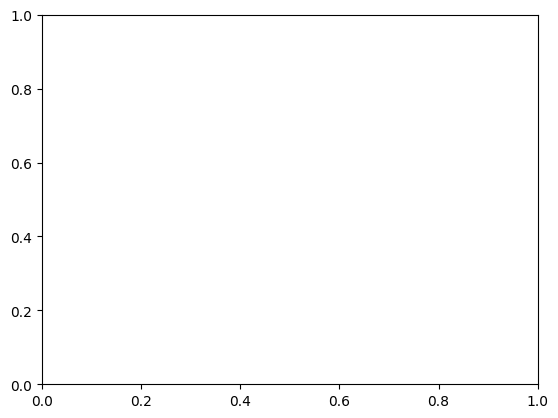

In [ ]:
import matplotlib.pyplot as plt

plt.plot(DDPG_agent.env.portfolio_history[1:])
print(DDPG_agent.env.portfolio_history)
plt.title("Portfolio Change Over Time")
plt.xlabel("Steps")
plt.ylabel("Portfolio value")
plt.show()